In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [2]:

# Step 1: Data cleaning
data = yf.download(tickers='BTC-usd', start='2014-12-31', end='2022-12-31', interval='1d')
#data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,320.192993,13942900
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
...,...,...,...,...,...,...
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2014-12-31 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2922 non-null   float64
 1   High       2922 non-null   float64
 2   Low        2922 non-null   float64
 3   Close      2922 non-null   float64
 4   Adj Close  2922 non-null   float64
 5   Volume     2922 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 159.8 KB


In [3]:
# Step 2: Feature engineering
data['RSI']       = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long']  = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2823 entries, 2015-04-09 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2823 non-null   float64
 1   High       2823 non-null   float64
 2   Low        2823 non-null   float64
 3   Adj Close  2823 non-null   float64
 4   Volume     2823 non-null   int64  
 5   RSI        2823 non-null   float64
 6   EMA_short  2823 non-null   float64
 7   EMA_long   2823 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 198.5 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2022-12-21,16904.527344,16916.800781,16755.912109,16817.535156,14882945045,46.354643,16990.208226,18631.716275
2022-12-22,16818.380859,16866.673828,16592.408203,16830.341797,16441573050,46.537922,16974.982852,18596.045493
2022-12-23,16829.644531,16905.218750,16794.458984,16796.953125,15329265213,46.097985,16958.027640,18560.419901
2022-12-24,16796.976562,16864.703125,16793.527344,16847.755859,9744636213,46.916068,16947.525565,18526.505762
2022-12-25,16847.505859,16860.554688,16755.253906,16841.986328,11656379938,46.829585,16937.474209,18493.148941
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,11886957804,48.209222,16935.791398,18461.993610
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,15748580239,44.954914,16914.970677,18427.442723
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,17005713920,42.460302,16880.456542,18390.316575
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,14472237479,44.267447,16857.778948,18355.703213


In [2]:
data= data.to_csv('btc-2015-2022_case1.csv')

NameError: name 'data' is not defined

In [5]:
from datetime import datetime

def date_parser(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    return date_obj.strftime('%m-%d-%Y')


In [2]:
data_csv = pd.read_csv('btc-2015-2022_case1.csv')
data_csv.dropna(inplace=True)
# Setting the index

data_csv.set_index('Date', inplace=True)
# Dropping any NaNs
data_csv.dropna(inplace=True)
data_csv.info()
data_csv

<class 'pandas.core.frame.DataFrame'>
Index: 2823 entries, 2015-04-09 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2823 non-null   float64
 1   High       2823 non-null   float64
 2   Low        2823 non-null   float64
 3   Adj Close  2823 non-null   float64
 4   Volume     2823 non-null   int64  
 5   RSI        2823 non-null   float64
 6   EMA_short  2823 non-null   float64
 7   EMA_long   2823 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 198.5+ KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2015-04-09,244.751007,246.117996,239.399994,243.675995,21643500,41.702661,253.715583,251.953280
2015-04-10,243.694000,243.694000,232.770996,236.072006,28882000,37.649141,252.035242,251.638800
2015-04-11,236.016006,239.537003,234.175003,236.552002,16365200,38.056357,250.560648,251.340051
2015-04-12,236.535004,237.727997,233.494995,236.153000,12387900,37.836271,249.188491,251.039318
2015-04-13,235.949997,236.934998,221.996002,224.587006,31181800,32.075186,246.845492,250.515509
...,...,...,...,...,...,...,...,...
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,11886957804,48.209222,16935.791398,18461.993610
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,15748580239,44.954914,16914.970677,18427.442723
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,17005713920,42.460302,16880.456542,18390.316575


In [3]:
# Split the data into training and test sets
train_df = data_csv[:int(len(data_csv)*0.8)]
test_df = data_csv[int(len(data_csv)*0.8):]
data_csv.shape


(2823, 8)

In [6]:
test_data =test_df.copy()

In [7]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time For BTC '
)

fig.show()


In [8]:
print(train_df.info())
print(test_df.info())
print('test_data', test_data.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 2258 entries, 2015-04-09 to 2021-06-13
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2258 non-null   float64
 1   High       2258 non-null   float64
 2   Low        2258 non-null   float64
 3   Adj Close  2258 non-null   float64
 4   Volume     2258 non-null   int64  
 5   RSI        2258 non-null   float64
 6   EMA_short  2258 non-null   float64
 7   EMA_long   2258 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 158.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 2021-06-14 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       565 non-null    float64
 1   High       565 non-null    float64
 2   Low        565 non-null    float64
 3   Adj Close  565 non-null    float64
 4   Volume     565 non-null    int64  
 5   RSI        565 non-null   

In [9]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (2258, 7)
y_train (2258,)
X_test (565, 7)
y_test (565,)


In [10]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1,1)
y_train = scaler.fit_transform(y_train)
y_test  = y_test.reshape(-1,1) 
y_test  = scaler.fit_transform(y_test)
#------------------------------------------
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape) 

x_train (2258, 7)
y_train (2258, 1)
X_test (565, 7)
y_test (565, 1)


In [11]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape)
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])


X_train (2258, 1, 7)
y_train (2258, 1)
X_test (565, 1, 7)
Y_test (565, 1)
X_train.shape[1] 1
X_train.shape[2] 7


In [20]:
# Step 6: Building the LSTM model (cont.)

model = Sequential()
model.add(LSTM(100, input_shape=( X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True, activation='tanh'))
model.add(Dropout(0.25))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['mean_absolute_error'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 100)            43200     
                                                                 
 dropout_4 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_5 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 75)             52800     
                                                                 
 dropout_6 (Dropout)         (None, 1, 75)             0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [21]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32)


Epoch 1/1000
71/71 [==============================] - 18s 14ms/step - loss: 0.0219 - mean_absolute_error: 0.0837
Epoch 2/1000
71/71 [==============================] - 1s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0247
Epoch 3/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.0015 - mean_absolute_error: 0.0193
Epoch 4/1000
71/71 [==============================] - 1s 17ms/step - loss: 0.0013 - mean_absolute_error: 0.0178
Epoch 5/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.0012 - mean_absolute_error: 0.0171
Epoch 6/1000
71/71 [==============================] - 1s 17ms/step - loss: 0.0011 - mean_absolute_error: 0.0179
Epoch 7/1000
71/71 [==============================] - 1s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0162
Epoch 8/1000
71/71 [==============================] - 1s 15ms/step - loss: 9.2468e-04 - mean_absolute_error: 0.0155
Epoch 9/1000
71/71 [==============================] - 1s 17ms/step - loss: 8.5486e-04 - mean_absolu

In [22]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()




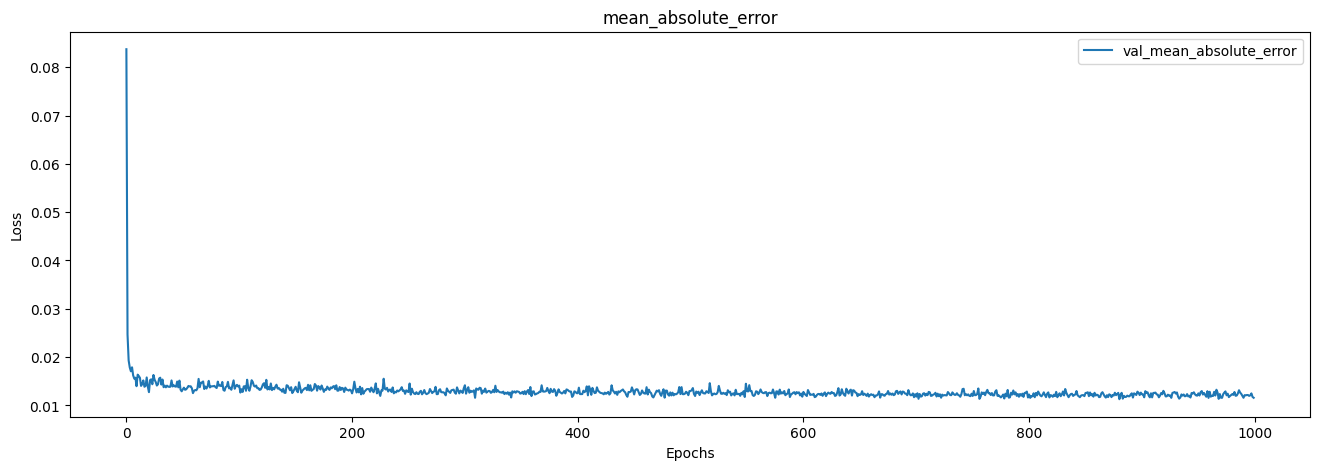

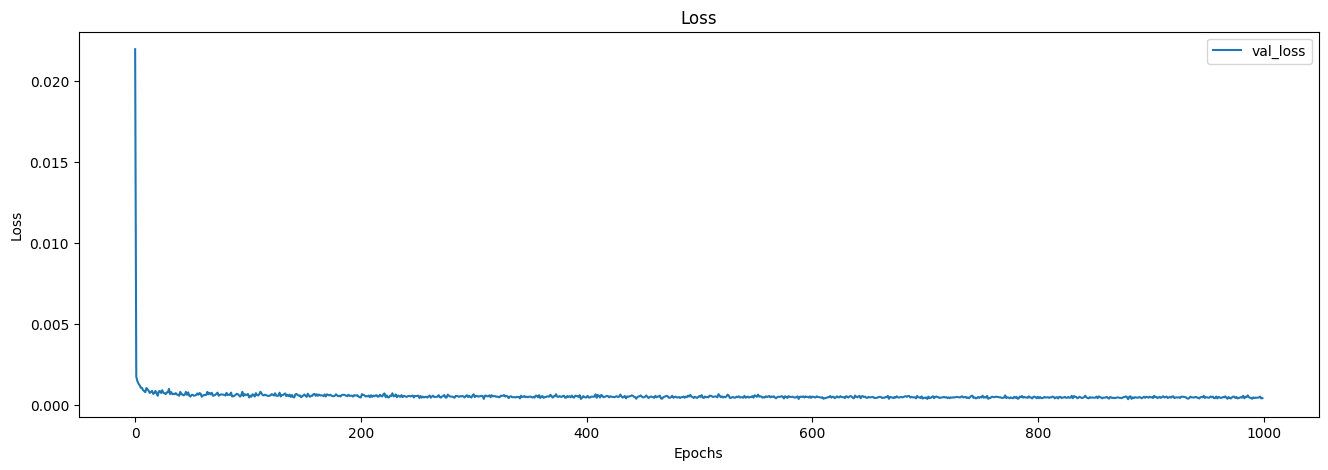

In [23]:
visualize_training_results(history)


In [24]:
# Evaluate the model on the test set
mse, mae = model.evaluate(X_test, y_test)


18/18 [==============================] - 5s 7ms/step - loss: 2.8588e-04 - mean_absolute_error: 0.0127


In [25]:

# Step 8: Testing the model
y_pred = model.predict(X_test)
print('y_pred', y_pred.shape)
print('y_test', y_test.shape)




# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


18/18 [==============================] - 4s 9ms/step
y_pred (565, 1)
y_test (565, 1)
RMSE: 0.0169
MSE: 0.0003
MAE:0.0127


In [27]:

# convert to original data
y_pred = scaler.inverse_transform(y_pred)
y_test= scaler.inverse_transform(y_test)

# evaluat

mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))

print("MAPE: {:.4f}%".format(mape))


MAPE: 1.8737%


In [31]:
y_pred_df = pd.DataFrame(y_pred, columns=["Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=["Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')
test_dates = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)


# Assuming y_pred is a numpy array




In [32]:

y_test_df.to_csv("y_test_2021_2022.csv")
y_test_df

,Adj Close
Date,
2021-06-14,40218.476562
2021-06-15,40406.269531
2021-06-16,38347.062500
2021-06-17,38053.503906
2021-06-18,35787.246094
...,...
2022-12-26,16919.804688
2022-12-27,16717.173828
2022-12-28,16552.572266


In [33]:
y_pred_df.to_csv("y_pred_2021_2022.csv")  # index=False to exclude index column in CSV
y_pred_df


,Adj Close
Date,
2021-06-14,41087.289062
2021-06-15,41390.023438
2021-06-16,40094.308594
2021-06-17,39608.449219
2021-06-18,37596.316406
...,...
2022-12-26,16610.609375
2022-12-27,16600.740234
2022-12-28,16478.583984


In [34]:

names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [27]:

# Step 1: Data cleaning
data_new = yf.download(tickers='BTC-USD', period='max', interval='1d')
data_new.dropna(inplace=True)
data_new


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-03-07,22428.322266,22527.417969,22011.261719,22219.769531,22219.769531,22765452204
2023-03-08,22216.441406,22268.896484,21708.050781,21718.080078,21718.080078,22536575684
2023-03-09,21720.080078,21802.716797,20210.306641,20363.021484,20363.021484,30364664171


In [28]:
# Step 2: Feature engineering
data_new['RSI']       = ta.rsi(data_new.Close, length=15)
data_new['EMA_short'] = ta.ema(data_new.Close, length=20)
data_new['EMA_long']  = ta.ema(data_new.Close, length=100)
data_new.dropna(inplace=True)
data_new.reset_index(inplace=True)
data_new.drop(['Close'], axis=1, inplace=True)
# Setting the index
data_new.set_index('Date', inplace=True)

# Dropping any NaNs
data_new.dropna(inplace=True)

data_new.info()
data_new.tail(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2999 entries, 2014-12-25 to 2023-03-11
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2999 non-null   float64
 1   High       2999 non-null   float64
 2   Low        2999 non-null   float64
 3   Adj Close  2999 non-null   float64
 4   Volume     2999 non-null   int64  
 5   RSI        2999 non-null   float64
 6   EMA_short  2999 non-null   float64
 7   EMA_long   2999 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 210.9 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,20386398516,52.763703,23444.603611,21191.250372
2023-03-03,23476.632812,23479.347656,22213.238281,22362.679688,26062404610,43.702150,23341.563237,21214.446992
2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,11166012913,43.634831,23247.447654,21236.999519
2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,13317001733,44.442323,23170.120608,21260.732473
2023-03-06,22436.816406,22584.292969,22331.314453,22429.757812,17353192895,44.394587,23099.609865,21283.881489
2023-03-07,22428.322266,22527.417969,22011.261719,22219.769531,22765452204,42.605759,23015.815548,21302.413926
2023-03-08,22216.441406,22268.896484,21708.050781,21718.080078,22536575684,38.622138,22892.221694,21310.644939
2023-03-09,21720.080078,21802.716797,20210.306641,20363.021484,30364664171,30.397245,22651.345483,21291.880118
2023-03-10,20367.001953,20370.595703,19628.253906,20187.244141,39578257695,29.523412,22416.669165,21270.006138


In [30]:
future_data = data_new.iloc[-30:, :]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Adj Close", "Volume", "RSI",
                                                 "EMA_short", "EMA_long"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today + timedelta(days=1), periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data = future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

# x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data = scaler.fit_transform(x_future_data)
y_future_data = scaler.fit_transform(y_future_data)
for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    # future_data_temp = future_data_temp.reshape(-1, 1)
    print("future_data_temp", future_data_temp.shape)


x_future_data: (30, 7)
y_future_data: (30, 1)
x_future_data: (30, 7)
future_data_temp (30, 7)
future_data_temp (29, 7)
future_data_temp (28, 7)
future_data_temp (27, 7)
future_data_temp (26, 7)
future_data_temp (25, 7)
future_data_temp (24, 7)
future_data_temp (23, 7)
future_data_temp (22, 7)
future_data_temp (21, 7)


In [31]:

# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]

    print("future_data_temp1", future_data_temp.shape)
    future_data_temp = np.reshape(future_data_temp, (future_data_temp.shape[0],
                                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3', future_data.shape)
print('prediction:', prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(
    prediction, index=future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test, end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)


future_data_temp1 (30, 7)
1/1 [==============================] - 0s 193ms/step
future_data_temp2 (30, 1, 7)
---------------------------------------------------
future_data_temp1 (29, 7)
1/1 [==============================] - 0s 79ms/step
future_data_temp2 (29, 1, 7)
---------------------------------------------------
future_data_temp1 (28, 7)
1/1 [==============================] - 0s 92ms/step
future_data_temp2 (28, 1, 7)
---------------------------------------------------
future_data_temp1 (27, 7)
1/1 [==============================] - 0s 102ms/step
future_data_temp2 (27, 1, 7)
---------------------------------------------------
future_data_temp1 (26, 7)
1/1 [==============================] - 0s 102ms/step
future_data_temp2 (26, 1, 7)
---------------------------------------------------
future_data_temp1 (25, 7)
1/1 [==============================] - 0s 153ms/step
future_data_temp2 (25, 1, 7)
---------------------------------------------------
future_data_temp1 (24, 7)
1/1 [===========

In [32]:
prediction_df


,Adj Close
2023-03-12,21478.434468
2023-03-13,21527.965553
2023-03-14,21549.907862
2023-03-15,21360.639882
2023-03-16,21654.107685
2023-03-17,22965.370249
2023-03-18,23750.524542
2023-03-19,23902.956995
2023-03-20,24380.667181
2023-03-21,24443.673089


In [33]:
y_future_data


,Adj Close
Date,
2023-02-10,21651.183594
2023-02-11,21870.875000
2023-02-12,21788.203125
2023-02-13,21808.101562
2023-02-14,22220.804688
2023-02-15,24307.841797
2023-02-16,23623.474609
2023-02-17,24565.601562
2023-02-18,24641.277344


In [34]:
names = cycle(['Predictions next 10 day', 'Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))

fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=y_future_data.index[-1], y1=y_future_data['Adj Close'][-1],
              line=dict(color='grey', width=2))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [35]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
              name='Predictions Data for 10 day'))

fig.add_shape(type='line',
              x0=actual_x[-1], y0=actual_y[-1],
              x1=pred_x[0], y1=pred_y[0],
              line=dict(color='grey', width=2, dash='dot'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()


In [36]:
future_data_all = data_new.copy()

future_data_all = pd.DataFrame(future_data_all, index= future_data_all.index, 
                               columns=future_data_all.columns)

x_future_data_all = future_data_all.drop(['Adj Close'], axis=1).values
y_future_data_all = future_data_all['Adj Close'].values
y_future_data_all = y_future_data_all.reshape(-1, 1)

print("x_future_data:", x_future_data_all.shape)
print("y_future_data:", y_future_data_all.shape)


x_future_data: (2999, 7)
y_future_data: (2999, 1)


In [37]:
x_future_data_all = scaler.fit_transform(x_future_data_all)
y_future_data_all = scaler.fit_transform(y_future_data_all)

x_future_data_all = np.reshape(x_future_data_all, (x_future_data_all.shape[0], 1, x_future_data_all.shape[1]))

pred_future_all = model.predict(x_future_data_all)


94/94 [==============================] - 1s 8ms/step


In [38]:

y_future_data_all = scaler.inverse_transform(y_future_data_all)
pred_future_all = scaler.inverse_transform(pred_future_all)
y_future_all = pd.DataFrame(y_future_data_all, index= future_data_all.index,  columns=['Adj Close'])
pred_future_all_df = pd.DataFrame(pred_future_all, index= future_data_all.index,  columns=['Adj Close'])
print("pred_future_all:", pred_future_all.shape)
print("y_future_data:", y_future_data_all.shape)

pred_future_all: (2999, 1)
y_future_data: (2999, 1)


In [39]:
names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_future_all.index, y=pred_future_all_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_future_all.index, y=y_future_all['Adj Close'], name='Actual Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='gray')))
fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=pred_future_all_df.index[-1], y1=pred_future_all_df['Adj Close'][-1],
              line=dict(color='grey', width=2))

fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()
